# AppStat project: Pendulum
Rune Ekman (njf458)


In [299]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from iminuit import Minuit
from iminuit.cost import LeastSquares


## Lengths

In [300]:
# Laser measurements from ceiling to floor  in meters
L_laser_s = [18.76, 18.76, 18.757, 18.759, 18.758, 18.758, 18.762, 18.758, 18.76, 18.758]
L_laser_s_toweight = [18.374, 18.378]
L_laser_m = [18.769, 18.764, 18.764, 18.763, 18.769, 18.759, 18.76, 18.758, 18.759, 18.759]
L_laser_r = [18.747, 18.749,18.780,18.774,18.790,18.784,18.771,18.780]
L_laser_a = [18.776,18.775,18.770,18.775,18.767,18.770]  

# Measured [to the top of weigth, to the bottom of the weigth] in meters
L_tape_s = [18.384, 18.416]
L_tape_m = [18.385, 18.415]
L_tape_r = [18.382, 18.419]
L_tape_a = [18.387, 18.416]

#From floor to weight in meters
floor_to_weight_r = [0.345, 0.345]
floor_to_weight_a = [0.346, 0.347, 0.347]
floor_to_weight = [0.345, 0.345,0.346, 0.347, 0.347]

#Hook on the tape measure in centimeters
tape_hook_s = [3, 2.95, 3, 3]

#Lets put it together in a matrix
laser_measurements = [L_laser_s, L_laser_m, L_laser_r, L_laser_a]
tape_measurements = [L_tape_s, L_tape_m, L_tape_r, L_tape_a]


Below we calculate the averages for each person for the laser, and then we do a weighted average of these. Combined to calculate distance to COM.

In [301]:
#Averages, laser
#Søren
sørenl = np.mean(L_laser_s)
sørenlsig = np.std(L_laser_s)#/np.sqrt(len(L_laser_s))
#Manon
manonl = np.mean(L_laser_m)
manonlsig = np.std(L_laser_m)#/np.sqrt(len(L_laser_m))
#Rune
runel = np.mean(L_laser_r)
runelsig = np.std(L_laser_r)#/np.sqrt(len(L_laser_r))
#Andreas
andreasl = np.mean(L_laser_a)
andreaslsig = np.std(L_laser_a)#/np.sqrt(len(L_laser_a))

combinedl = np.array([sørenl,manonl,runel,andreasl])
combinedlsig = np.array([sørenlsig, manonlsig, runelsig, andreaslsig])

print("Lengths (Avg) of Søren, manon, rune, andreas",sørenl, manonl, runel, andreasl)
print("stds, same order ",sørenlsig, manonlsig, runelsig, andreaslsig)


#Calculating weighted average of all the lengths to the floor
weights = 1/combinedlsig**2
avglengthtobottom = np.sum(combinedl*weights)/np.sum(weights)
unctobottom = np.sqrt(1/np.sum(weights))
print("Weighted average for each person, to the bottom",avglengthtobottom, "+-", unctobottom)


#Calculating distance to COM
floortow = np.mean(floor_to_weight)
floortow_unc = np.std(floor_to_weight)/np.sqrt(len(floor_to_weight))

ceilingtow = np.mean(L_laser_s_toweight)
ceilingtow_unc = np.std(L_laser_s_toweight)/np.sqrt(len(L_laser_s_toweight))

#Distance to COM (weighted) using laser
L_laser = avglengthtobottom - floortow - (avglengthtobottom - floortow - ceilingtow)/2
L_laser_unc = np.sqrt((1/4)*unctobottom**2 + (3/2)**2 *floortow_unc**2 + (1/4)*ceilingtow_unc**2)

print("Distance to COM, as given by laser",L_laser,"+-", L_laser_unc)

Lengths (Avg) of Søren, manon, rune, andreas 18.759 18.762400000000003 18.771875 18.772166666666667
stds, same order  0.0014142135623735673 0.003903844259187956 0.014810785765785876 0.0033374973990832556
Weighted average for each person, to the bottom 18.76121809716788 +- 0.0012309605230866052
Distance to COM, as given by laser 18.39560904858394 +- 0.001113021092499934


Below we calculate the distance to the COM using the tape measure.

In [302]:
#Lengths to the top
L_tape_top = [L_tape_s[0], L_tape_m[0], L_tape_r[0], L_tape_a[0]]
L_tape_top_std = np.std(L_tape_top)
L_tape_top_mean = np.mean(L_tape_top)
#Lengths to the bottom
L_tape_bot = [L_tape_s[1], L_tape_m[1], L_tape_r[1], L_tape_a[1]]
L_tape_bot_std = np.std(L_tape_bot)
L_tape_bot_mean = np.mean(L_tape_bot)

#Hook deviation measurement
tape_hook_s_mean = 0.001*np.mean(tape_hook_s)
tape_hook_s_std = 0.001*np.std(tape_hook_s)

#Combining the stds with the 0.5mm imprecision by adding in quadrature
L_tape_top_unc = np.sqrt(0.0005**(2) + L_tape_top_std**2)
L_tape_bot_unc = np.sqrt(0.0005**(2) + L_tape_bot_std**2)
tape_hook_s_unc = np.sqrt(0.0005**(2) + tape_hook_s_mean**2)


def err(da, db, dc):
    df = np.sqrt(((1/2)*da)**2 + ((1/2)*db)**2 + (-dc)**2)
    return df

weight_measure = (L_tape_bot_mean - ((L_tape_bot_mean-L_tape_top_mean)/2)) - tape_hook_s_mean #The final estimate ofthe length with tape measure
weight_measure_uncertainty = err(L_tape_bot_unc, L_tape_top_unc, tape_hook_s_unc) #The uncertainty on the above value


print(weight_measure, weight_measure_uncertainty)

18.3975125 0.003267285761913094


In [303]:
#Taking weighted average of the lengths
avg_length = (L_laser*(1/L_laser_unc**2) + weight_measure*(1/weight_measure_uncertainty**2))/(1/weight_measure_uncertainty**2 + 1/L_laser_unc**2)
avg_length_unc = np.sqrt(1/(1/weight_measure_uncertainty**2 + 1/L_laser_unc**2))
print("avg length",avg_length, avg_length_unc)
#Calculating chi2 and prob for the lengths
chi2_length = (((L_laser)-avg_length) / L_laser_unc)**2 + (((weight_measure)-avg_length) / weight_measure_uncertainty)**2
chi2_length_prob = stats.chi2.sf(chi2_length, 1)
print("Chi2 prob for the lengths", chi2_length_prob)

avg length 18.39580696964156 0.0010535671563221918
Chi2 prob for the lengths 0.5813188248791605


# Timing

## The function

In [304]:
def ALL(file, bins, L, sig_L, sig_T):
    
    #Defining our data, first for the period
    testfile1 = file #These files should include ONLY the counts and the times.
    
    testdata1 = np.genfromtxt(file, delimiter='\t', names=('n', 't_s'))
    testdata1 = testdata1[::2]
    constant = testdata1[0][1]
    for i in range(len(testdata1)):
        testdata1[i][0] = i
        testdata1[i][1] = testdata1[i][1] - constant
    n1,t1 = testdata1["n"], testdata1["t_s"] #Defines my two arrays from the data
    sigt1 = sig_T #Our uncertainty in elapsed time.


    #Defining straight line function to be used in fitting
    def line(x,a,b):
        y= a*x+b 
        return y

    #Defining chi2 function for line:
    def chi2_owncalc_line(Period,Offset) :
        y_fit = line(n1,Period,Offset) #observe that we in this function input our data (n1 and t1)!!
        chi2 = np.sum(((t1 - y_fit) / sigt1)**2)
        return chi2
    
    #Performing the actual fit
    m = Minuit(chi2_owncalc_line,Period=8, Offset=0)
    m.errordef = 1.0     # This is the definition for ChiSqaure fits
    m.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('PERIOD VALUES')
    if (not m.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in m.parameters :
        value, error = m.values[name], m.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value_line = m.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value_line = len(n1) - m.nfit

    Prob_value = stats.chi2.sf(chi2_value_line, Ndof_value_line) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value_line:.1f}   Ndof = {Ndof_value_line:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.5f}")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12,4))
    ax_res = ax.inset_axes([0,-0.412,0.898,0.4]) #add the residual plot
    ax_gauss = ax.inset_axes([0.902,-0.412,0.098,0.4]) #add the gauss part

    ax.errorbar(n1, t1, yerr=sigt1, color='k', fmt='o', label="Data")
    ax.set_ylabel('Time elapsed (s)', fontsize=18)
    ax.set(xlim=(0, n1[-1]+np.ediff1d(n1)[0]), ylim=(0, t1[-1]+np.ediff1d(t1)[0]), xticklabels=[])
    #Enter the fit
    ax.plot(n1, line(n1, *m.values), label="Fit")

    fit_info = [
        f"$\\chi^2$={chi2_value_line:.1f}",
        f"$n_\\mathrm{{dof}}$={Ndof_value_line:.0f}",
        f"Prob(Chi2,Ndof) = {Prob_value:5.3f}",
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

    ax.text(0.95, 0.01, "\n".join(fit_info),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=15)

    ax.legend( frameon=False, loc="upper left")


    #Create residual plot
    residual = line(n1,m.values[0], m.values[1]) - t1
    ax_res.errorbar(n1,residual, yerr= sigt1, fmt="o", color="k")
    ax_res.axhline(y=0, linestyle="dashed", color="red")
    ax_res.set_ylabel("Residuals", fontsize=18)
    ax_res.set_xlabel('Timing measurement number', fontsize=18)

    
    #Calculating residual histogram stuff

    xmin=min(residual)-0.01
    xmax=max(residual)+0.01
    Nbins = bins
    binwidth = (xmax-xmin)/Nbins #needed for normalization, see the Gauss function
    counts, bin_edges = np.histogram(residual, bins=Nbins, range=(xmin,xmax))
    x = (bin_edges[1:] + bin_edges[:-1])/2
    y = counts

    # Making sure non-zero bins
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy=np.sqrt(y)

    #Creating Gaussian fit
    #First defining the Gauss function
    def gauss_pdf(val,A,mu,sigma):
        return len(y) *binwidth* A*stats.norm.pdf(val,mu,sigma)

    # Defining Chi2 calculation:
    def chi2_owncalc(A, mu, sigma) :
        y_fit = gauss_pdf(x, A, mu, sigma)
        chi2 = np.sum(((y - y_fit) / sy)**2)
        return chi2

    #Performing the actual fit
    minuit_chi2 = Minuit(chi2_owncalc,A=5, mu=0, sigma=0.05)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('RESIDUAL GAUSSIAN VALUES')
    if (not minuit_chi2.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    N_NotEmptyBin = np.sum(y > 0)
    Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")


    
    #Plotting histogram of residuals
    ax_gauss.hist(residual, bins=Nbins, orientation="horizontal", histtype='step', linewidth=2, color='red', label='Residuals')
    x_axis = np.linspace(xmin, xmax, 1000)
    ax_gauss.plot(gauss_pdf(x_axis, *minuit_chi2.values[:]),x_axis, '-r', label='Chi2 fit model result') 
    
    ax_gauss.set(xlim=ax_gauss.get_xlim()[::-1],yticklabels=[],ylabel='Residual histogram')
    ax_gauss.yaxis.set_label_position("right")


    def g(T, L, sig_T, sig_L):
        g=L*(2*np.pi/(T))**2
        sig_g = np.sqrt((2*np.pi/T)**4 * sig_L**2 + ((2*L*(2*np.pi)**2)/T**3)**2 * sig_T**2)
        return g, sig_g
    
    g_val = g(m.values['Period'], L, m.errors['Period'], sig_L)
    #print('g value =', g(m.values['a'], 18.4, m.errors['a'], 0.001))
    print(g_val)
    return m.values['Period'] , m.errors['Period'] , g_val


## The good data

Running the function below

PERIOD VALUES
Fit value: Period = 8.59434 +/- 0.00332
Fit value: Offset = 0.08244 +/- 0.03303
Chi2 value: 12.4   Ndof = 16    Prob(Chi2,Ndof) = 0.71579
RESIDUAL GAUSSIAN VALUES
Fit value: A = 2.65254 +/- 0.86153
Fit value: mu = 0.01054 +/- 0.03119
Fit value: sigma = 0.07333 +/- 0.03546
Chi2 value: 1.4   Ndof = 4    Prob(Chi2,Ndof) = 0.846
(9.832273550245445, 0.0076092187476168105)
PERIOD VALUES
Fit value: Period = 8.60410 +/- 0.00188
Fit value: Offset = 0.02835 +/- 0.01760
Chi2 value: 13.6   Ndof = 15    Prob(Chi2,Ndof) = 0.55303
RESIDUAL GAUSSIAN VALUES
Fit value: A = 2.30546 +/- 0.62517
Fit value: mu = 0.00199 +/- 0.01142
Fit value: sigma = 0.03790 +/- 0.01178
Chi2 value: 1.9   Ndof = 4    Prob(Chi2,Ndof) = 0.755
(9.80996950225043, 0.004315326564752664)


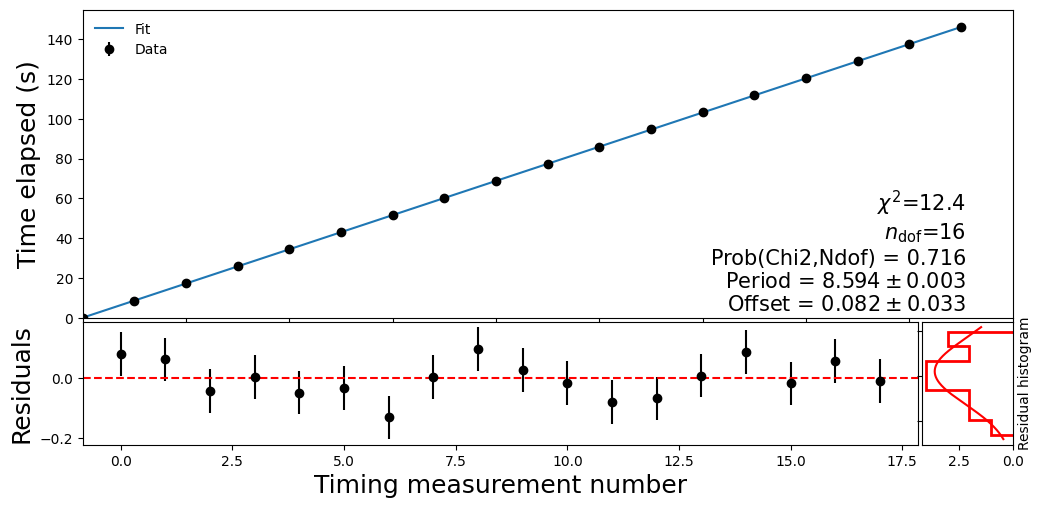

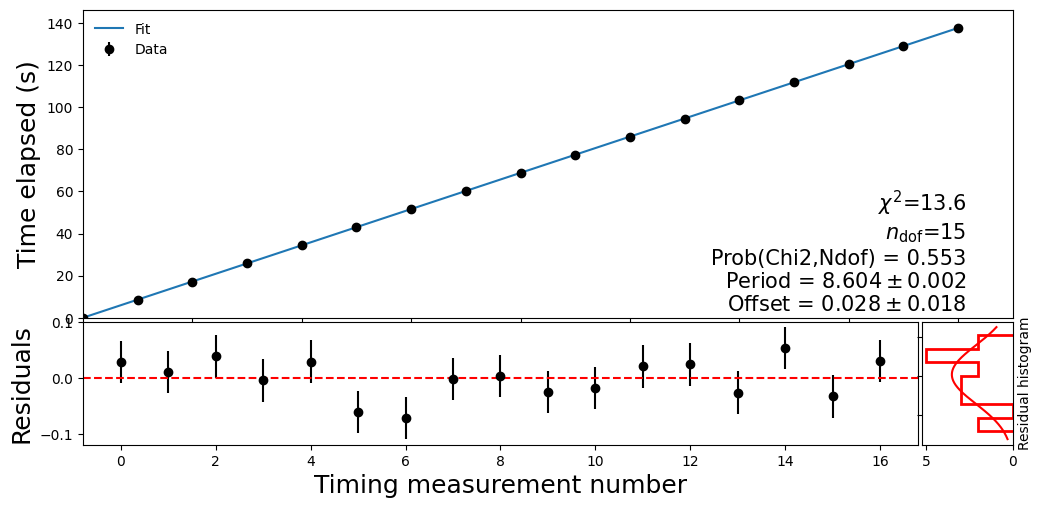

In [305]:
test3 = ALL("rune3.dat", bins=7, L= avg_length, sig_L= avg_length_unc, sig_T=0.073)
test4 = ALL("rune4.dat", bins=7, L= avg_length, sig_L= avg_length_unc, sig_T=0.0379)

Calculate g below:

In [306]:
slopes = np.array([test3[0], test4[0]])
slope_uncs = np.array([test3[1], test4[1]])
slope_weights = 1/(slope_uncs**2)

mean_slope = np.sum(slopes*slope_weights)/np.sum(slope_weights)
unc_slope = np.sqrt(1/np.sum(slope_weights))

chi2_slope = np.sum(((slopes-mean_slope)/slope_uncs**2))
chi2_slope_prob = stats.chi2.sf(chi2_slope, 1)

def g(T, L, sig_T, sig_L):
    g=L*(2*np.pi/(T))**2
    sig_g = np.sqrt((2*np.pi/T)**4 * sig_L**2 + ((2*L*(2*np.pi)**2)/T**3)**2 * sig_T**2)
    print("L contribution to g",(2*np.pi/T)**4 * sig_L**2)
    print("T contribution to g", ((2*L*(2*np.pi)**2)/T**3)**2 * sig_T**2)
    return g, sig_g
print(g(T=mean_slope , L=avg_length , sig_T= unc_slope, sig_L = avg_length_unc))
print("chi2 prob slope", chi2_slope_prob)
print("mean slope", mean_slope, "+/-" , unc_slope)

L contribution to g 3.1600952219803355e-07
T contribution to g 1.3890488717281051e-05
(9.815370665871233, 0.003769150864515652)
chi2 prob slope 0.9999878074267242
mean slope 8.60173260409292 +/- 0.0016330820313095358


## The weird data
Creates another fit with an added quadratic term. Adds both fits in the same figure, along with residual.
Calculate std of gaussian fit to the residuals. Add this value to the appendix.
Function is below.

In [316]:
def ALL_weird(file, bins, L, sig_L, sig_T, skip):
    
    #Defining our data, first for the period
    testfile1 = file #These files should include ONLY the counts and the times.
    
    testdata1 = np.genfromtxt(file, delimiter='\t', names=('n', 't_s'), skip_header=skip)
    testdata1 = testdata1[::2]
    constant = testdata1[0][1]
    for i in range(len(testdata1)):
        testdata1[i][0] = i
        testdata1[i][1] = testdata1[i][1] - constant
    n1,t1 = testdata1["n"], testdata1["t_s"] #Defines my two arrays from the data
    sigt1 = sig_T  #Our uncertainty in elapsed time.


    #Defining straight line function to be used in fitting
    def line(x,a,b):
        y= a*x+b 
        return y
    #Defininf 2nd degree polynomial for comparison
    def parab(x,a,b,k):
        y=a*x+b +k*x**2
        return y

    #Defining chi2 function for line:
    def chi2_owncalc_line(Slope,Offset) :
        y_fit = line(n1,Slope,Offset) #observe that we in this function input our data (n1 and t1)!!
        chi2 = np.sum(((t1 - y_fit) / sigt1)**2)
        return chi2
    
    #Defining chi2 function for parab
    def chi2_owncalc_parab(Linear,Constant,Quadratic) :
        y_fit = parab(n1,Linear,Constant,Quadratic) #observe that we in this function input our data (n1 and t1)!!
        chi2 = np.sum(((t1 - y_fit) / sigt1)**2)
        return chi2
    
    #Performing the actual fit, line
    m = Minuit(chi2_owncalc_line,Slope=8, Offset=0)
    m.errordef = 1.0     # This is the definition for ChiSqaure fits
    m.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('PERIOD VALUES')
    if (not m.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in m.parameters :
        value, error = m.values[name], m.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value_line = m.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value_line = len(n1) - m.nfit

    Prob_value = stats.chi2.sf(chi2_value_line, Ndof_value_line) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value_line:.1f}   Ndof = {Ndof_value_line:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.5f}")
    

    #PErforming the fit for parab
    m2 = Minuit(chi2_owncalc_parab,Linear=8, Constant=0 , Quadratic=-0.1)
    m2.errordef = 1.0     # This is the definition for ChiSqaure fits
    m2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('PERIOD VALUES')
    if (not m2.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in m2.parameters :
        value2, error2 = m2.values[name], m2.errors[name]
        print(f"Fit value: {name} = {value2:.5f} +/- {error2:.5f}")

    # Get Chi2 value:
    chi2_value_parab = m2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value_parab = len(n1) - m2.nfit

    Prob_value2 = stats.chi2.sf(chi2_value_parab, Ndof_value_parab) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value_parab:.1f}   Ndof = {Ndof_value_parab:.0f}    Prob(Chi2,Ndof) = {Prob_value2:5.5f}")
    

    # Plotting
    fig, ax = plt.subplots(figsize=(12,6))
    ax_res = ax.inset_axes([0,-0.412*0.5,0.898,0.4*0.5]) #add the residual plot
    ax_res_2 = ax.inset_axes([0,-0.412,0.898,0.4*0.5]) #add the residual plot for parabola
    ax_gauss = ax.inset_axes([0.902,-0.412*0.5,0.098,0.4*0.5]) #add the gauss part, line
    ax_gauss_2 = ax.inset_axes([0.902,-0.412,0.098,0.4*0.5]) #add the gauss part, line

    ax.errorbar(n1, t1, yerr=sigt1, color='k', fmt='o', label="Data")
    ax.set_ylabel('Time elapsed (s)', fontsize=18)
    ax.set(xlim=(0, n1[-1]+np.ediff1d(n1)[0]), ylim=(0, t1[-1]+np.ediff1d(t1)[0]), xticklabels=[])
    #Enter the fit, line
    ax.plot(n1, line(n1, *m.values), label="Linear fit")
    ax.plot(n1, parab(n1, *m2.values), label="Parabola fit")

    fit_info1 = [
        f"Linear $\\chi^2$={chi2_value_line:.1f}",
        f"$n_\\mathrm{{dof}}$={Ndof_value_line:.0f}", 
        f"Prob(Chi2,Ndof) = {Prob_value:5.3f}",

    ]
    fit_info2 = [
        f"Parabola $\\chi^2$={chi2_value_parab:.1f}" ,
        f"$n_\\mathrm{{dof}}$={Ndof_value_parab:.0f}",
        f"Prob(Chi2,Ndof) = {Prob_value2:5.3f}"
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info1.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    
    for p, v, e in zip(m2.parameters, m2.values, m2.errors):
        fit_info2.append(f"{p} term= ${v:.3f} \\pm {e:.3f}$")
    
    ax.text(0.95, 0.01, "\n".join(fit_info1),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=15)

    ax.text(0.01,0.8, "\n".join(fit_info2),
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        fontsize=15)

    ax.legend(frameon=False, loc="upper left")


    #Create residual plot (line)
    residual = line(n1,m.values[0], m.values[1]) - t1
    ax_res.errorbar(n1,residual, yerr=sigt1, fmt="o", color="k")
    ax_res.axhline(y=0, linestyle="dashed", color="red")
    ax_res.set_ylabel("Line", fontsize=14)
    
    #Create residual plot (parabola)
    residual2 = parab(n1,*m2.values) - t1
    ax_res_2.errorbar(n1,residual2,yerr=sigt1, fmt="o", color="k")
    ax_res_2.axhline(y=0, linestyle="dashed", color="red")
    ax_res_2.set_ylabel("Parabola", fontsize=14)
    
    ax_res_2.set_xlabel('Timing measurement number', fontsize=18)

    
    #Residual histogram for parabola
    xmin=min(residual2)-0.01
    xmax=max(residual2)+0.01
    Nbins = bins
    binwidth = (xmax-xmin)/Nbins #needed for normalization, see the Gauss function
    counts, bin_edges = np.histogram(residual2, bins=Nbins, range=(xmin,xmax))
    x = (bin_edges[1:] + bin_edges[:-1])/2
    y = counts

    # Making sure non-zero bins
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy=np.sqrt(y)

    #Creating Gaussian fit
    #First defining the Gauss function
    def gauss_pdf(val,A,mu,sigma):
        return len(y) *binwidth* A*stats.norm.pdf(val,mu,sigma)

    # Defining Chi2 calculation:
    def chi2_owncalc(A, mu, sigma) :
        y_fit = gauss_pdf(x, A, mu, sigma)
        chi2 = np.sum(((y - y_fit) / sy)**2)
        return chi2

    #Performing the actual fit
    minuit_chi2 = Minuit(chi2_owncalc,A=5, mu=0, sigma=0.05)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSquare fits
    minuit_chi2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('RESIDUAL GAUSSIAN VALUES')
    if (not minuit_chi2.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    N_NotEmptyBin = np.sum(y > 0)
    Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

    
    #Plotting histogram of residuals, parabola
    ax_gauss_2.hist(residual2, bins=Nbins, orientation="horizontal", histtype='step', linewidth=2, color='red', label='Residuals')
    x_axis = np.linspace(xmin, xmax, 1000)
    ax_gauss_2.plot(gauss_pdf(x_axis, *minuit_chi2.values[:]),x_axis, '-b', label='Chi2 fit model result') 
    
    ax_gauss_2.set(xlim=ax_gauss_2.get_xlim()[::-1],yticklabels=[],ylabel='Parabola histogram')
    ax_gauss_2.yaxis.set_label_position("right")

    #PLotting line residual histogram
    ax_gauss.hist(residual, bins=Nbins, orientation="horizontal", histtype='step', linewidth=2, color='red', label='Residuals')
    ax_gauss.set(xlim=ax_gauss.get_xlim()[::-1],yticklabels=[],ylabel='Linear histogram')
    ax_gauss.yaxis.set_label_position("right")

    return minuit_chi2.values['sigma'] , minuit_chi2.errors['sigma']
    
    

## Søren

PERIOD VALUES
Fit value: Slope = 7.83785 +/- 0.00111
Fit value: Offset = -0.86242 +/- 0.01230
Chi2 value: 4687.2   Ndof = 18    Prob(Chi2,Ndof) = 0.00000
PERIOD VALUES
Fit value: Linear = 7.55808 +/- 0.00424
Fit value: Constant = -0.02311 +/- 0.01738
Fit value: Quadratic = 0.01472 +/- 0.00022
Chi2 value: 14.0   Ndof = 17    Prob(Chi2,Ndof) = 0.66875
RESIDUAL GAUSSIAN VALUES
Fit value: A = 4.72071 +/- 1.14279
Fit value: mu = -0.00220 +/- 0.00794
Fit value: sigma = 0.02854 +/- 0.00707
Chi2 value: 0.1   Ndof = 2    Prob(Chi2,Ndof) = 0.947
PERIOD VALUES
Fit value: Slope = 7.83959 +/- 0.00190
Fit value: Offset = -0.68805 +/- 0.02117
Chi2 value: 1448.2   Ndof = 18    Prob(Chi2,Ndof) = 0.00000
PERIOD VALUES
Fit value: Linear = 7.57370 +/- 0.00730
Fit value: Constant = 0.10962 +/- 0.02991
Fit value: Quadratic = 0.01399 +/- 0.00037
Chi2 value: 23.2   Ndof = 17    Prob(Chi2,Ndof) = 0.14258
RESIDUAL GAUSSIAN VALUES
Fit value: A = 3.05654 +/- 0.72037
Fit value: mu = -0.00324 +/- 0.01217
Fit value:

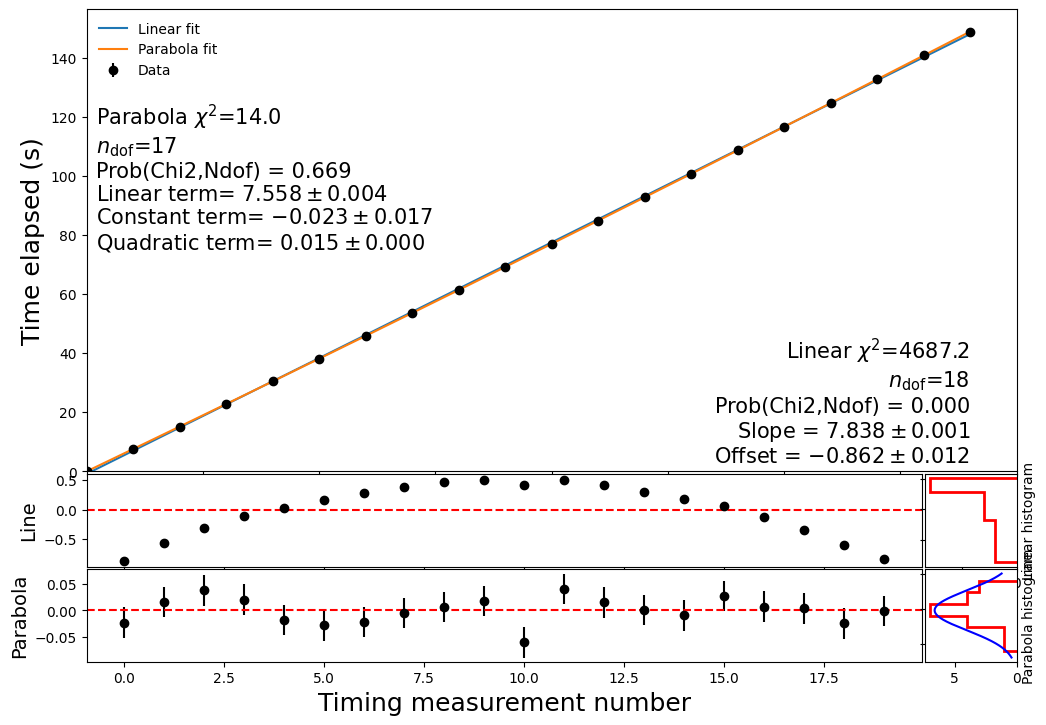

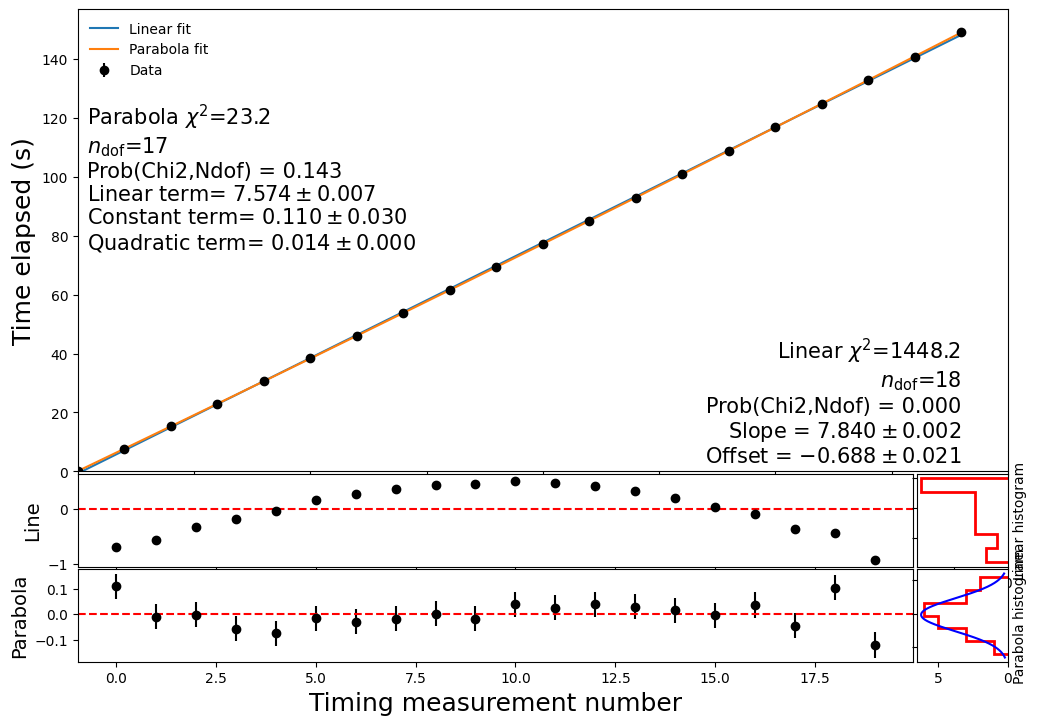

In [317]:
#First data file for Søren
sørenresult1 = ALL_weird("søren2.dat", bins=6, L= avg_length, sig_L= avg_length_unc, sig_T=0.02854, skip=0)
#Second file for Søren
sørenresult2 = ALL_weird("søren2.dat", bins=6, L= avg_length, sig_L= avg_length_unc, sig_T=0.04912, skip=1)

def weighted_mean_weird(val1, val2, unc1, unc2):
    mean=(val1*(1/unc1)**2 + val2*(1/unc2)**2) / ((1/unc1)**2 +(1/unc2)**2)
    unc = 1/np.sqrt((1/unc1)**2 +(1/unc2)**2)
    return mean,unc

søren_time = weighted_mean_weird(sørenresult1[0], sørenresult2[0], sørenresult1[1], sørenresult2[1])

In [309]:
print(søren_time)

(0.03151344677704337, 0.006543094731249326)


## Andreas

PERIOD VALUES
Fit value: Slope = 8.00403 +/- 0.00159
Fit value: Offset = -1.63338 +/- 0.02321
Chi2 value: 5168.0   Ndof = 24    Prob(Chi2,Ndof) = 0.00000
PERIOD VALUES
Fit value: Linear = 7.57750 +/- 0.00616
Fit value: Constant = 0.07274 +/- 0.03323
Fit value: Quadratic = 0.01706 +/- 0.00024
Chi2 value: 22.3   Ndof = 23    Prob(Chi2,Ndof) = 0.50031
RESIDUAL GAUSSIAN VALUES
Fit value: A = 4.48641 +/- 0.92054
Fit value: mu = 0.00688 +/- 0.01376
Fit value: sigma = 0.06088 +/- 0.01466
Chi2 value: 0.3   Ndof = 3    Prob(Chi2,Ndof) = 0.954
PERIOD VALUES
Fit value: Slope = 7.98482 +/- 0.00173
Fit value: Offset = -1.42794 +/- 0.02416
Chi2 value: 3833.8   Ndof = 23    Prob(Chi2,Ndof) = 0.00000
PERIOD VALUES
Fit value: Linear = 7.58733 +/- 0.00666
Fit value: Constant = 0.09580 +/- 0.03453
Fit value: Quadratic = 0.01656 +/- 0.00027
Chi2 value: 19.0   Ndof = 22    Prob(Chi2,Ndof) = 0.64556
RESIDUAL GAUSSIAN VALUES
Fit value: A = 3.85099 +/- 0.91042
Fit value: mu = 0.00795 +/- 0.01631
Fit value: si

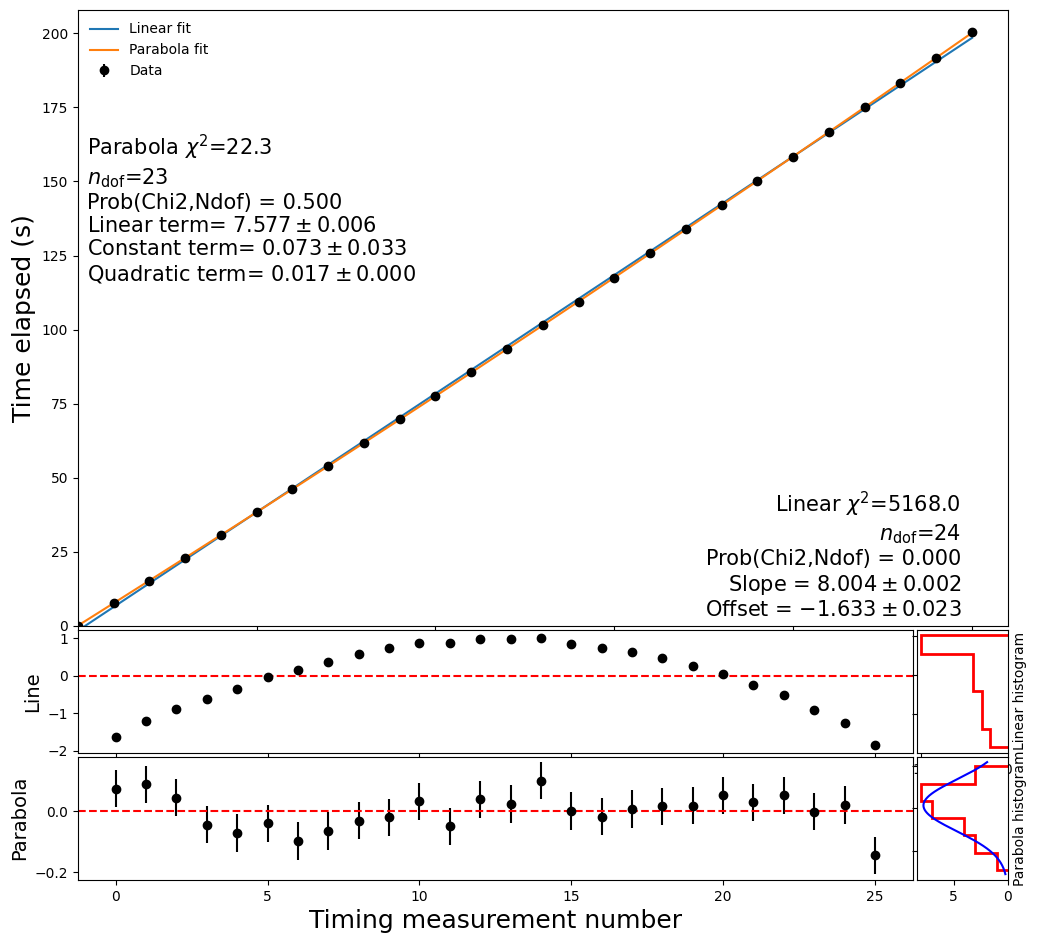

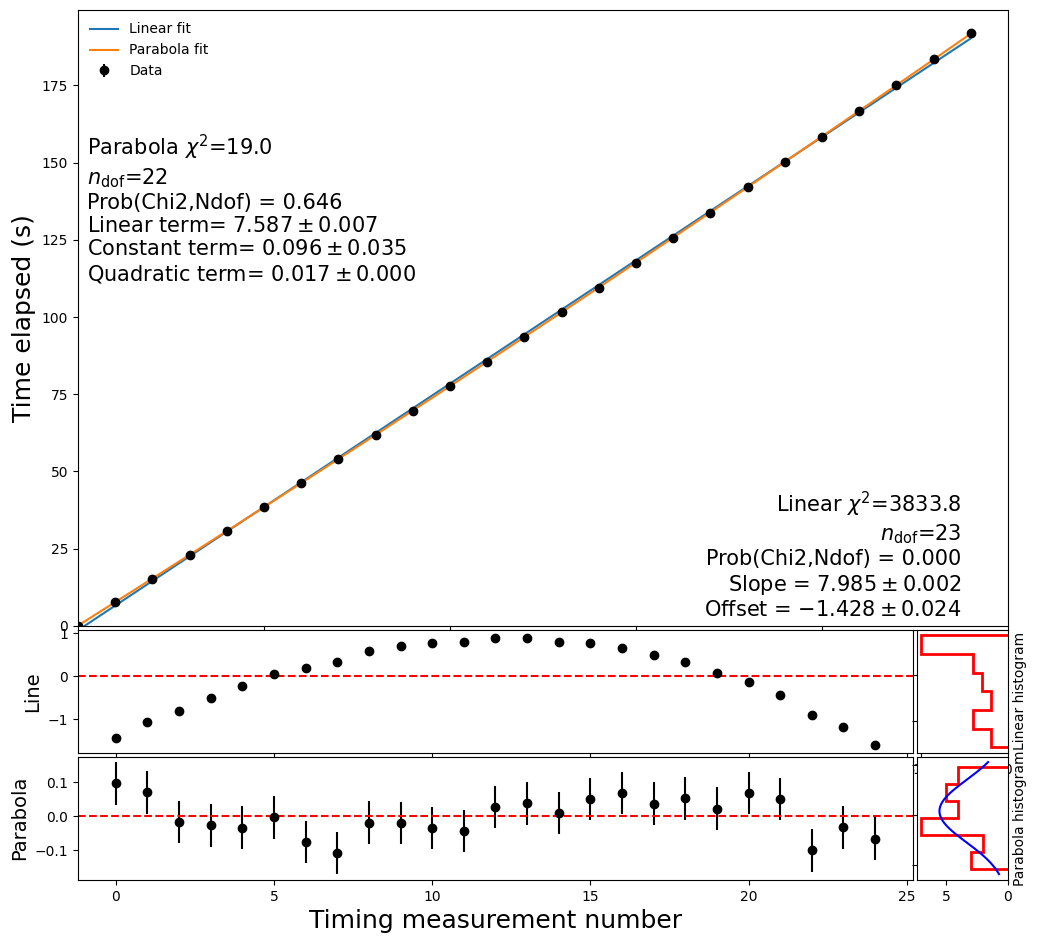

In [310]:
andreasresult1 = ALL_weird("andreas2.dat", bins=6, L= avg_length, sig_L= avg_length_unc, sig_T=0.06088, skip=0)
andreasresult2 = ALL_weird("andreas2.dat", bins=6, L= avg_length, sig_L= avg_length_unc, sig_T=0.06221 , skip=1)

andreas_time = weighted_mean_weird(andreasresult1[0], andreasresult2[0], andreasresult1[1], andreasresult2[1])

In [311]:
print(andreas_time)

(0.061393238642876026, 0.011504149432525056)


## Manon

PERIOD VALUES
Fit value: Slope = 8.09599 +/- 0.00328
Fit value: Offset = -0.98505 +/- 0.03646
Chi2 value: 686.9   Ndof = 18    Prob(Chi2,Ndof) = 0.00000
PERIOD VALUES
Fit value: Linear = 7.77945 +/- 0.01257
Fit value: Constant = -0.03541 +/- 0.05152
Fit value: Quadratic = 0.01666 +/- 0.00064
Chi2 value: 6.2   Ndof = 17    Prob(Chi2,Ndof) = 0.99163
RESIDUAL GAUSSIAN VALUES
Fit value: A = 4.66624 +/- 2.64014
Fit value: mu = -0.01548 +/- 0.04026
Fit value: sigma = 0.08461 +/- 0.06066
Chi2 value: 0.4   Ndof = 3    Prob(Chi2,Ndof) = 0.934
PERIOD VALUES
Fit value: Slope = 8.08969 +/- 0.00213
Fit value: Offset = -0.84741 +/- 0.02249
Chi2 value: 1640.4   Ndof = 17    Prob(Chi2,Ndof) = 0.00000
PERIOD VALUES
Fit value: Linear = 7.77207 +/- 0.00816
Fit value: Constant = 0.05252 +/- 0.03168
Fit value: Quadratic = 0.01765 +/- 0.00044
Chi2 value: 13.8   Ndof = 16    Prob(Chi2,Ndof) = 0.61075
RESIDUAL GAUSSIAN VALUES
Fit value: A = 2.61567 +/- 0.72810
Fit value: mu = -0.00720 +/- 0.01643
Fit value: s

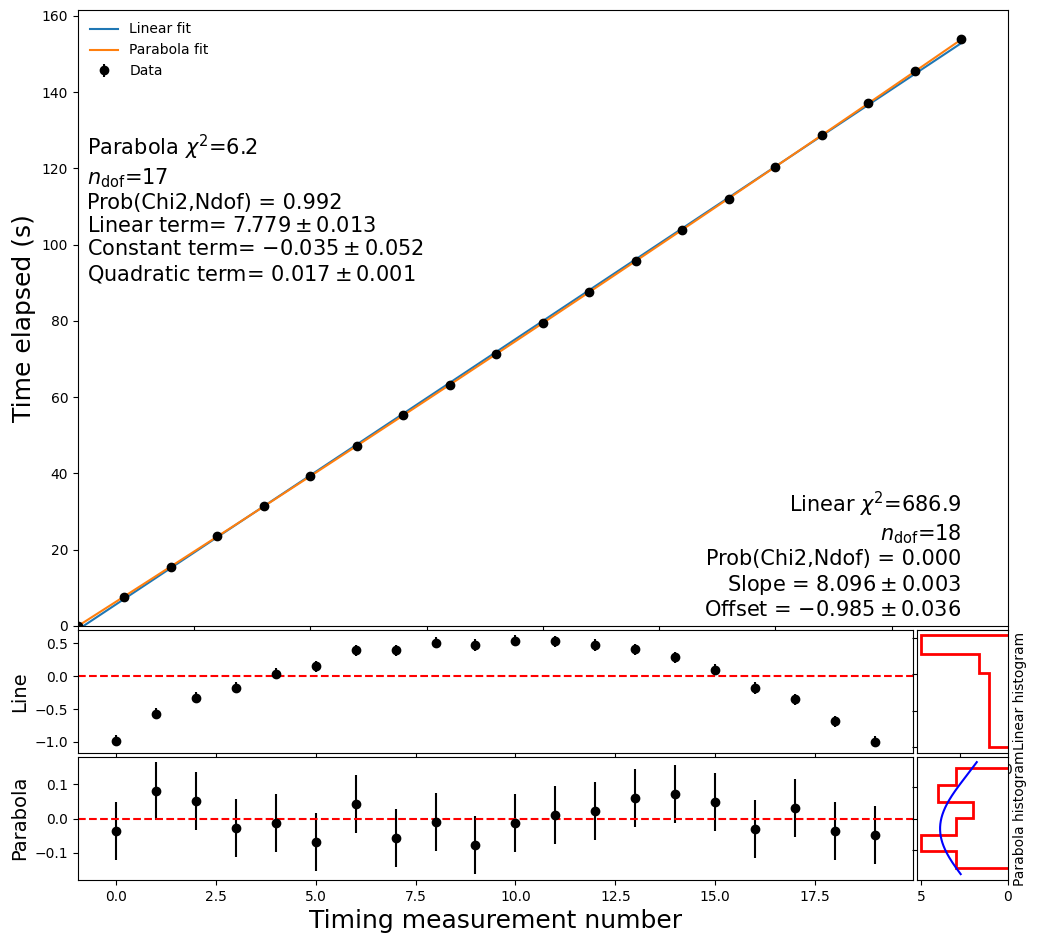

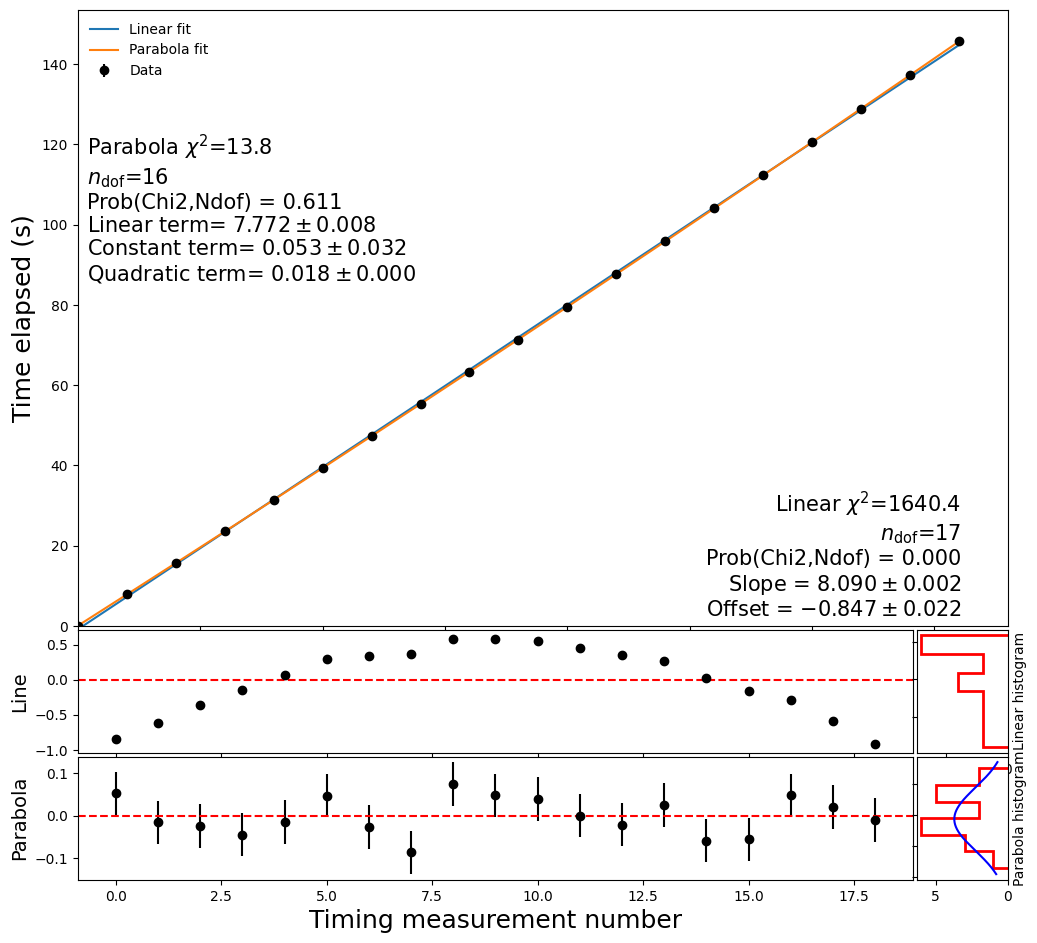

In [312]:
manonresult1 = ALL_weird("manon1.dat", bins=6, L= avg_length, sig_L= avg_length_unc, sig_T=0.08461 , skip=11 )
manonresult2 = ALL_weird("manon1.dat", bins=6, L= avg_length, sig_L= avg_length_unc, sig_T=0.05096 , skip=12 )

manon_time = weighted_mean_weird(manonresult1[0], manonresult2[0], manonresult1[1], manonresult2[1])

In [313]:
print(manon_time)

(0.05298244882769384, 0.014868358345620343)


With Manon's data we see a weird break after the 6th datapoint. We have no explanation for this. We see that the data shows the parabola trend we recognize from Søren's and Andreas' data, then jumps, and then again follows the trend.

My best bet: the pendulum hit something or Manon moved her head.

One possible way: ignore the first 6 data points. If we skip these entirely, then it follows the trend we recognize. This is the only way I can think of to still estimate her accuracy.